# Final Project 

# Part One: Data Cleaning

In [5]:
# Load packages 
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import geopandas
import pdfplumber
import numpy as np
import bokeh
import seaborn as sns
import statsmodels.api as sm
import PyPDF2
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
from ipywidgets import interact, interact_manual, RadioButtons, Dropdown
from bokeh.io import output_notebook
from bokeh.models.widgets import Panel, Tabs
from mpl_toolkits.axes_grid1 import make_axes_locatable
from statsmodels.tsa.api import ExponentialSmoothing
import descartes
from shapely.geometry import Point, Polygon
import shapely.speedups
shapely.speedups.enable()
from shapely.geometry import Point
from wordcloud import WordCloud
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import Holt

# Crime number in 15 Police districts

In [15]:
table_settings = {
    "vertical_strategy": "text",
    "horizontal_strategy": "text"
}
path = r'c:\users\wuyiwei\desktop\final\crime_in_25_districts'

In [16]:
# Read pdfs
def read_pdf(fname):
    pdf = pdfplumber.open(os.path.join(path, fname))
    table = pdf.pages[0].extract_table(table_settings)
    df = pd.DataFrame(table[1::],columns = table[0])
    return df

In [17]:
# Select and clean data in line 21-28
def clean_pdf(df):
    df_loc = df.loc[21:28, :]
    df_loc[df_loc.columns[[0, 1, 2]]].apply(
    lambda x: ''.join(x.dropna()),
    axis = 1
)
    df_int = df_loc.iloc[:, 4:6].astype(str).astype(int)
    df_loc['2020'] = df_int.apply(
    lambda x: ''.join(x.dropna().astype(str)),
    axis = 1)
    df_loc['Crime Type'] = df_loc[df_loc.columns[[0, 1, 2]]].apply(
    lambda x: ''.join(x.dropna()),
    axis = 1)
    df_drop = df_loc.drop(columns = df_loc.columns[0:3])
    df_drop.columns = ['2021','delete_1','delete_2','delete_3','2019','2018','delete_4',
              '2017','delete_5','delete_6','delete_7','delete_8','delete_9', '2020','Crime Type']
    df_drop.drop(['delete_1','delete_2','delete_3','delete_4','delete_5','delete_6','delete_7','delete_8','delete_9'],
             axis = 1, inplace = True)
    return df_drop

In [18]:
# Add district number in each dataframe
def add_district(df, district_number):
    df['District'] = district_number
    return df

In [19]:
# Merge dataframes
def concat_df(frames):
    result = pd.concat(frames)
    result.to_csv(path+'/result.csv')
    return result

In [20]:
# Creat a new variable 'year'
def melt_result(result):
    result_melt = result.melt(id_vars = ['Crime Type','District'], var_name = 'Year', value_name = 'Crime Number')
    return result_melt

In [21]:
name_list = ['02', '03', '04', '05', '06', '08', '09', '10', '11', '12', '14', '17', '18', '22', '25']

In [22]:
def get_df_from_pdf(x):
    file_to_read = x + '.pdf'
    df = read_pdf(file_to_read)
    df = clean_pdf(df)
    df = add_district(df, x)
    return df

for x in name_list:
    get_df_from_pdf(x)
    
for item in name_list:
    dataframe_list = []
    df = get_df_from_pdf(item)
    dataframe_list.append(df)
    
result = concat_df(dataframe_list)
result_melt = melt_result(result)

<ipython-input-17-a9f87f547fdd>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loc['2020'] = df_int.apply(
<ipython-input-17-a9f87f547fdd>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loc['Crime Type'] = df_loc[df_loc.columns[[0, 1, 2]]].apply(
C:\Users\wuyiwei\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [28]:
result_melt.to_csv(r'c:\users\wuyiwei\desktop\final\Crime number in 15 Police districts.csv')

# Police districts map

In [29]:
# Load the file
def read_police_map(path_police_map):
    df_police  = geopandas.read_file(path_police_map)
    return df_police

In [30]:
# Add districts names to dataframe
def district_names(df_police):
    dict = {'1ST':'Central',
        '2ND':'Wentworth', 
        '3RD':'Grand Crossing', 
        '4TH':'South Chicago', 
        '5TH':'Calumet', 
        '6TH':'Gresham', 
        '7TH':'Englewood', 
        '8TH':'Chicago Lawn', 
        '9TH':'Deering', 
        '10TH':'Ogden', 
        '11TH':'Harrison', 
        '12TH':'Near West', 
        '14TH':'Shakespeare', 
        '15TH':'Austin', 
        '16TH':'Jefferson Park', 
        '17TH':'Albany Park', 
        '18TH':'Near North', 
        '19TH':'Town Hall', 
        '20TH':'Lincoln', 
        '22ND':'Morgan Park', 
        '24TH':'Rogers Park', 
        '25TH':'Grand Central',
        '31ST':'-'}
    df_police_names = df_police.replace(dict)
    return df_police_names

In [31]:
# Merge police districts map with crime numbers in 15 Police districts
def districts_merge(df_police_names, result_melt):
    police_district_merge = pd.merge(df_police_names, result_melt, how = 'outer', left_on = 'dist_num', right_on = 'District')
    return police_district_merge

In [32]:
# Clean dataframe
def districts_clean(police_district_merge):
    police_district_clean = police_district_merge.dropna()
    police_district = police_district_clean.drop(columns = police_district_clean.columns[4])
    police_district.iloc[:, [5]] = police_district.iloc[:, [5]].astype(str).astype(int)
    return police_district

In [33]:
path_police_map = r'c:\users\wuyiwei\desktop\final\police_districts_map\geo_export_7cae4e7a-d6ef-4074-a683-b90e5387d710.shp'
df_police = read_police_map(path_police_map)
df_police_names = district_names(df_police)
police_district_merge = districts_merge(df_police_names, result_melt)
police_district = districts_clean(police_district_merge)

In [34]:
police_district.to_csv(r'c:\users\wuyiwei\desktop\final\Police districts map.csv')

# Chicago Neighborhood Map

In [35]:
# Load the file
def read_police_map(path_neighborhood):
    chicago_neighborhood  = geopandas.read_file(path_neighborhood)
    chicago_neighborhood = chicago_neighborhood.to_crs('EPSG:4326')
    return chicago_neighborhood

In [36]:
path_neighborhood = r'c:\users\wuyiwei\desktop\final\neighborhood/CommAreas.shp'
chicago_neighborhood = read_police_map(path_neighborhood)

In [37]:
chicago_neighborhood.to_csv(r'c:\users\wuyiwei\desktop\final\Chicago Neighborhood Map.csv')

# Crime in October, 2021

In [38]:
# Load the file
def read_police_map(path_neighborhood):
    crime_in_Chicago = pd.read_csv(path_neighborhood)
    return crime_in_Chicago

In [39]:
# Select crime data in Oct, 2021
def select_oct_data(crime_in_Chicago):
    start_date = '10/01/2021'
    end_date = '10/31/2021'
    after_start_date = crime_in_Chicago["DATE  OF OCCURRENCE"] >= start_date
    before_end_date = crime_in_Chicago["DATE  OF OCCURRENCE"] <= end_date
    between_two_dates = after_start_date & before_end_date
    Oct_df= crime_in_Chicago.loc[between_two_dates]
    
    crs = {'init':'epsg:4326'}
    crime_geometry = [Point(xy) for xy in zip (Oct_df['LONGITUDE'],Oct_df['LATITUDE'])]
    geo_crime_oct = geopandas.GeoDataFrame (Oct_df, crs = crs, geometry = crime_geometry)
    return geo_crime_oct

In [40]:
path_neighborhood = r'c:\users\wuyiwei\desktop\final\Crimes.csv'
crime_in_Chicago = read_police_map(path_neighborhood)
geo_crime_oct = select_oct_data(crime_in_Chicago)

C:\Users\wuyiwei\anaconda3\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [41]:
geo_crime_oct.to_csv(r'c:\users\wuyiwei\desktop\final\Crime in October 2021.csv')

# Crime cases till Year 2021

In [42]:
# Load the file
def crimes_in_Chicago_neighbourhood(crime_in_Chicago, chicago_neighborhood):
    crime_geometry_2021 = [Point(xy) for xy in zip (crime_in_Chicago['LONGITUDE'],crime_in_Chicago['LATITUDE'])]
    crs = {'init':'epsg:4326'}
    geo_crime_2021 = geopandas.GeoDataFrame (crime_in_Chicago, crs = crs, geometry = crime_geometry_2021)
    crime_in_neighbourhood = geopandas.tools.sjoin(geo_crime_2021, chicago_neighborhood, op = "within", how = 'inner')
    crime_in_neighbourhood['ARREST'].replace({'Y':1, 'N': 0}, inplace=True)
    crime_in_neighbourhood['ARREST'].mean()
    return crime_in_neighbourhood

In [43]:
# Generate dataframe 'df_arrestRate'
def generate_arrestRate(crime_in_neighbourhood):
    df_arrestRate = crime_in_neighbourhood.groupby(['COMMUNITY'])['ARREST'].mean().reset_index()
    return df_arrestRate

In [44]:
# Merge df_arrestRate with chicago_neighborhood
def merge_chicagoArrest(chicago_neighborhood, df_arrestRate):
    df_chicagoArrest = pd.merge(chicago_neighborhood, df_arrestRate, on = 'COMMUNITY')
    return df_chicagoArrest

In [45]:
crime_in_neighbourhood = crimes_in_Chicago_neighbourhood(crime_in_Chicago, chicago_neighborhood)
df_arrestRate = generate_arrestRate(crime_in_neighbourhood)
df_chicagoArrest = merge_chicagoArrest(chicago_neighborhood, df_arrestRate)

C:\Users\wuyiwei\anaconda3\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\wuyiwei\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-42-780b903a7696>:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  crime_in_neighbourhood = geopandas.tools.sjoin(geo_crime_202

In [46]:
df_chicagoArrest.to_csv(r'c:\users\wuyiwei\desktop\final\Crime cases till Year 2021.csv')

# Crime 2010 to present

In [54]:
def clean_Crimes_2010_to_Present(path_clean_Crimes_2010_to_Present):
    Crimes_2010_to_Present =  pd.read_csv(path_clean_Crimes_2010_to_Present)
    Crimes_2010_to_Present.drop(['Case Number', 'IUCR', 'X Coordinate', 'Y Coordinate','Updated On','Year', 'FBI Code', 'Beat','Ward','Community Area', 'Location', 'District', 'Latitude' , 'Longitude'], inplace=True, axis=1)
    Crimes_2010_to_Present.Date = pd.to_datetime(Crimes_2010_to_Present.Date, format='%m/%d/%Y %I:%M:%S %p')
    Crimes_2010_to_Present.index = pd.DatetimeIndex(Crimes_2010_to_Present.Date)
    return Crimes_2010_to_Present

In [55]:
path_clean_Crimes_2010_to_Present = r'c:\users\wuyiwei\desktop\final\Crimes_2010_to_Present.csv'
Crimes_2010_to_Present = clean_Crimes_2010_to_Present(path_clean_Crimes_2010_to_Present)

In [57]:
Crimes_2010_to_Present.to_csv(r'c:\users\wuyiwei\desktop\final\2010 to present.csv')

# Part two: Data visualization

# Interactive plot: Crime Distribution in 15 Police Districts¶

In [25]:
Location_list = ['Albany Park', 'Wentworth', 'Grand Crossing', 'South Chicago', 
                 'Calumet', 'Gresham', 'Chicago Lawn', 'Deering', 'Ogden', 
                 'Harrison', 'Near West', 'Shakespeare', 'Albany Park', 
                 'Near North', 'Morgan Park', 'Grand Central']
Year_list = ['2018', '2019', '2020', '2021']
Crime_list = ['AGG BATTERY', 'BURGLARY', 'CRIM SEXUAL ASSLT', 'MTR VEHICLE THEFT', 'MURDER', 'ROBBERY', 'THEFT', 'TOTAL']

In [26]:
@interact(Year = Year_list, Crime = Crime_list)
def crime_distribution(Crime = 'TOTAL', Year = '2021'):
    fig, ax = plt.subplots(figsize=(20,20))
    selected_district = police_district[police_district['Crime Type'] == Crime][police_district['Year'] == Year]
    ax = selected_district.plot(ax = ax, column = 'Crime Number', legend = True)
    selected_district.apply(lambda x: ax.annotate(text = x.dist_label, xy = x.geometry.centroid.coords[0], ha = 'center', color = "white"), axis=1)
    ax.set_title('Crime Distribution in 15 Police Districts')

interactive(children=(Dropdown(description='Crime', index=7, options=('AGG BATTERY', 'BURGLARY', 'CRIM SEXUAL …

# Interactive plot: Top 5 high crime locations

In [27]:
@interact(Year = Year_list, Crime = Crime_list)
def top5_locations(Crime = 'TOTAL', Year = '2021'):
    selected_district = police_district[police_district['Crime Type'] == Crime][police_district['Year'] == Year]
    top5 = selected_district.iloc[selected_district['Crime Number'].argsort()[-5:]]
    top5 = top5.sort_values(by = 'Crime Number', ascending=False)
    
    fig, ax = plt.subplots(figsize = (10, 7))
    ax.bar(x = top5['dist_label'], 
       height = top5['Crime Number'],
       width = 0.4,
       align = 'center')
    ax.set_title('Top 5 high crime locations', fontsize=15)
    plt.xlabel('Locations', fontsize = 15, color = 'grey')
    plt.ylabel('Crime Number', fontsize = 15, color = 'grey')

interactive(children=(Dropdown(description='Crime', index=7, options=('AGG BATTERY', 'BURGLARY', 'CRIM SEXUAL …

# Interactive plot: Crime trend in the past years

In [28]:
@interact(Crime = Crime_list)
def crime_trend(Crime = 'TOTAL'):
    annual_crime_number = []
    for year in range (0,4):
        select_year = police_district[police_district['Year'] == Year_list[year]]
        select_crime = select_year[select_year['Crime Type'] == Crime]
        total_crime = sum(select_crime['Crime Number'])
        annual_crime_number.append(total_crime)
    
    crime_trend = pd.DataFrame({'Year':Year_list, 'Crime Number':annual_crime_number}) 
    fig, ax = plt.subplots(figsize = (10, 7))
    plt.plot(crime_trend['Year'], crime_trend['Crime Number'], marker = '*', ms = 10)
    plt.xlabel('Year', fontsize = 15, color = 'grey')
    plt.ylabel('Crime Number', fontsize = 15, color = 'grey')
    plt.title(Crime)

    plt.show()

interactive(children=(Dropdown(description='Crime', index=7, options=('AGG BATTERY', 'BURGLARY', 'CRIM SEXUAL …

# Interactive plot: Crime Types in Chicago Neighbourhood

In [29]:
crime_names = geo_crime_oct.reset_index()[' PRIMARY DESCRIPTION'].unique()

In [30]:
@interact(crime = crime_names)
def make_plot_for(crime = crime_names[0]):
    fig, ax = plt.subplots(figsize=(25,25))
    ax = chicago_neighborhood.plot(ax = ax, alpha=0.2, color = 'grey',edgecolor = 'black')
    geo_crime_oct[geo_crime_oct[' PRIMARY DESCRIPTION'] == crime].plot(ax = ax, color = 'red', marker = 'o', markersize = 5, label = 'homicide')
    chicago_neighborhood.apply(lambda x: ax.annotate(text = x.COMMUNITY, xy = x.geometry.centroid.coords[0], ha = 'center', color = "black"), axis = 1)
    ax.set_title('Crime Distribution in Oct 2021 of Chicago')
    ax.axis('off');

interactive(children=(Dropdown(description='crime', options=('THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'MOTOR VEH…

# Arrest rate of neighbourhood in Chicago

In [31]:
def plot_arrestRate(df):
    fig, ax = plt.subplots(figsize=(32,32))
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size = '5%', pad=0.1)
    
    ax = df_chicagoArrest.plot(ax = ax, column = 'ARREST', legend = True, cax = cax)
    df.apply(lambda x: ax.annotate(text = x.COMMUNITY, xy = x.geometry.centroid.coords[0], ha = 'center', color = "White",fontsize = 12), axis = 1)
    ax.axis('off')
    ax.set_title('Arrest Rate of Crime in Chicago City (2021)', fontsize = 26)
    plt.show();

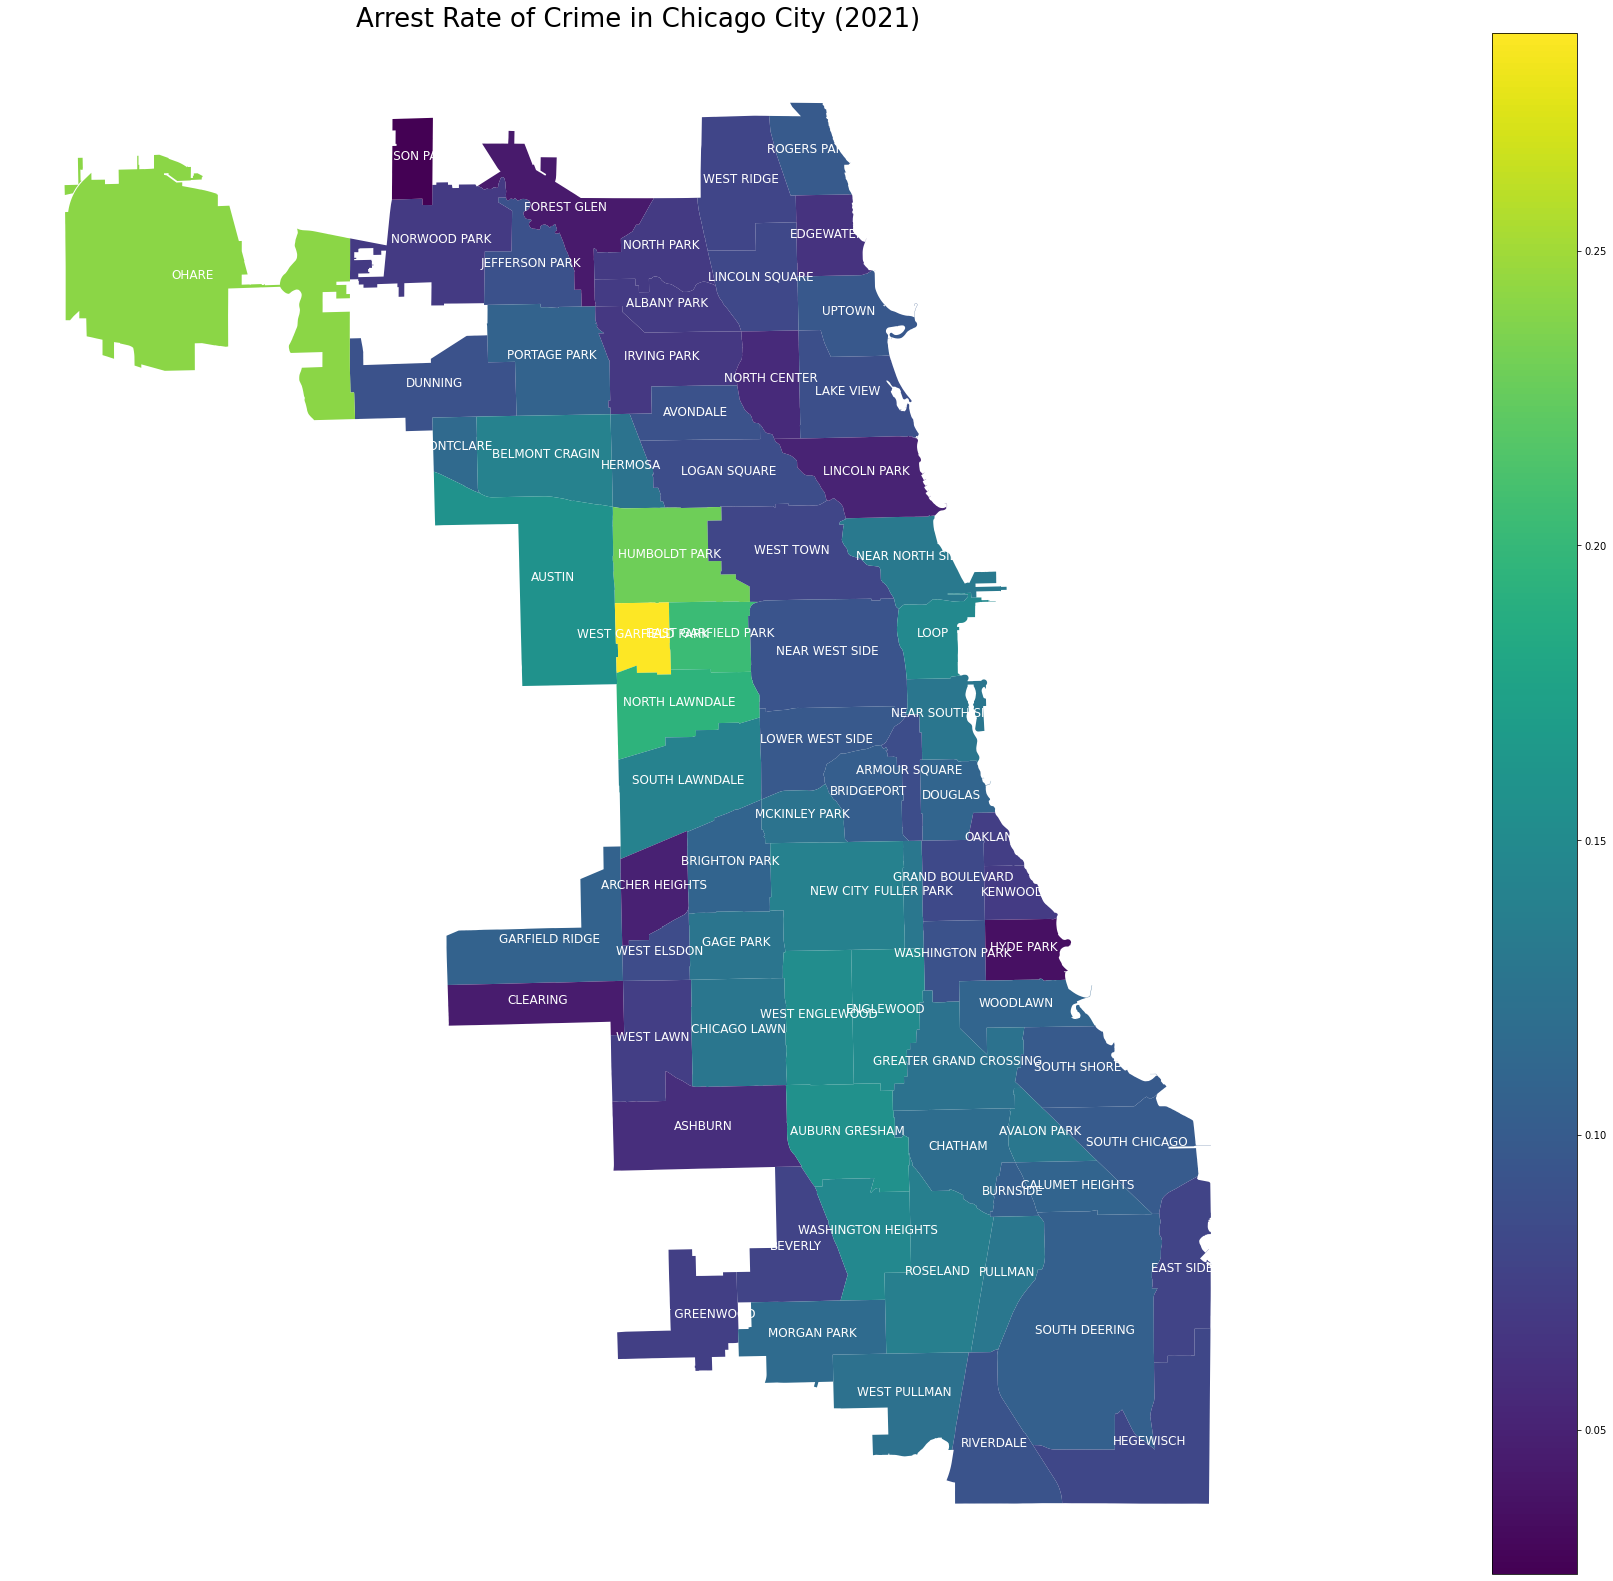

In [32]:
plot_arrestRate(df_chicagoArrest)

# Pie chart: crime types

In [35]:
crime_sizes = crime_in_neighbourhood.iloc[:,[4]].value_counts().sort_values(ascending=False)
crime_sizes = crime_sizes.head(10)
str = [''.join(crime_sizes.index[0]), ''.join(crime_sizes.index[1]), ''.join(crime_sizes.index[2]), ''.join(crime_sizes.index[3]), 
      ''.join(crime_sizes.index[4]), ''.join(crime_sizes.index[5]), ''.join(crime_sizes.index[6]), ''.join(crime_sizes.index[7]),
      ''.join(crime_sizes.index[8]),''.join(crime_sizes.index[9])]
crime_sizes.index = str


In [38]:
def piechart(crime_in_neighbourhood):
    labels = [q for q in str]
    fig, ax = plt.subplots(figsize = (6,5))
    ax.pie(crime_sizes.values, labels = labels);

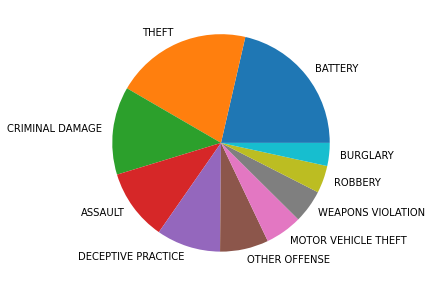

In [39]:
piechart(crime_in_neighbourhood)

# Word Cloud: high crime types

In [40]:
def wc_high_crime_types(crime_sizes):
    wc = WordCloud().generate_from_frequencies(crime_sizes)
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

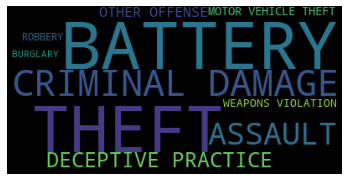

In [41]:
wc_high_crime_types(crime_sizes)

In [42]:
def sort_location_size(crime_in_neighbourhood):
    location_size = crime_in_neighbourhood.iloc[:,[6]].value_counts().sort_values(ascending=False)
    location_size = location_size.head(10)
    str2 = [''.join(location_size.index[0]), ''.join(location_size.index[1]), ''.join(location_size.index[2]), ''.join(location_size.index[3]), 
      ''.join(location_size.index[4]), ''.join(location_size.index[5]), ''.join(location_size.index[6]), ''.join(location_size.index[7]),
      ''.join(location_size.index[8]),''.join(location_size.index[9])]
    location_size.index = str2
    return location_size

# Word Cloud: high crime locations

In [43]:
def wc_high_crime_locations(location_size):
    wc = WordCloud().generate_from_frequencies(location_size)
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

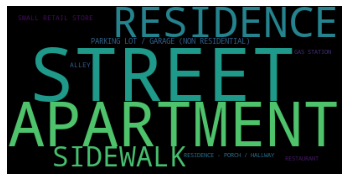

In [44]:
location_size = sort_location_size(crime_in_neighbourhood)
wc_high_crime_locations(location_size)

# Heatmap: crime distribution by month and date

In [45]:
def sort_by_month_and_date(crime_in_neighbourhood):
    df = crime_in_neighbourhood
    df.iloc[:,[1]]
    df[['Date', 'Time', 'AM/PM']] = df['DATE  OF OCCURRENCE'].str.split(' ', expand=True)
    df[['Month', 'Day', 'Year']] = df['Date'].str.split('/', expand = True)
    sizes_data = df['Date'].value_counts().sort_values(ascending = False)
    sizes_number = pd.DataFrame(sizes_data.values, columns = ['Number'])
    sizes_date = pd.DataFrame(sizes_data.index, columns = ['Date'])
    sizes_concat = pd.concat([sizes_number, sizes_date], axis = 1)
    sizes_concat[['Month', 'Day', 'Year']] = sizes_concat['Date'].str.split('/', expand=True)
    sizes_concat = sizes_concat.pivot('Day', 'Month', 'Number')
    sns.heatmap(sizes_concat)

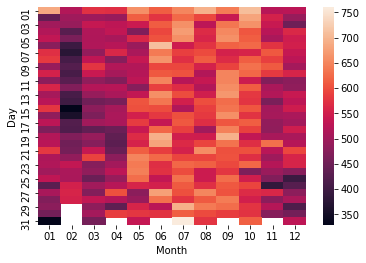

In [46]:
sort_by_month_and_date(crime_in_neighbourhood)

# Part 3: Prediction

In [47]:
# Reshape the data
def resample_dataframe(Crimes_2010_to_Present):
    chicago_prophet = Crimes_2010_to_Present.resample('M').size().reset_index()
    chicago_prophet.columns = ['Date', 'Crime Count']
    chicago_prophet_df = pd.DataFrame(chicago_prophet)
    chicago_prophet_df_final = chicago_prophet_df.rename(columns={'Date':'ds', 'Crime Count':'y'})
    chicago_prophet_df_final.index = chicago_prophet_df_final['ds']
    return chicago_prophet_df_final

In [48]:
chicago_prophet_df_final = resample_dataframe(Crimes_2010_to_Present)

In [49]:
# Creat train group and test group
train = chicago_prophet_df_final[0:100]
test = chicago_prophet_df_final[101:]

# Method 1: Naive Forecast

In [50]:
def naive_forecast(train, test):
    dd = np.asarray(train['y'])
    y_hat = test.copy()
    y_hat['naive'] = dd[len(dd) - 1]
    plt.figure(figsize = (12, 8))
    plt.plot(train.index, train['y'], label = 'Train')
    plt.plot(test.index, test['y'], label = 'Test')
    plt.plot(y_hat.index, y_hat['naive'], label = 'Naive Forecast')
    plt.legend(loc = 'best')
    plt.title("Naive Forecast")
    plt.show()
    
    rms = sqrt(mean_squared_error(test['y'], y_hat['naive']))
    return rms

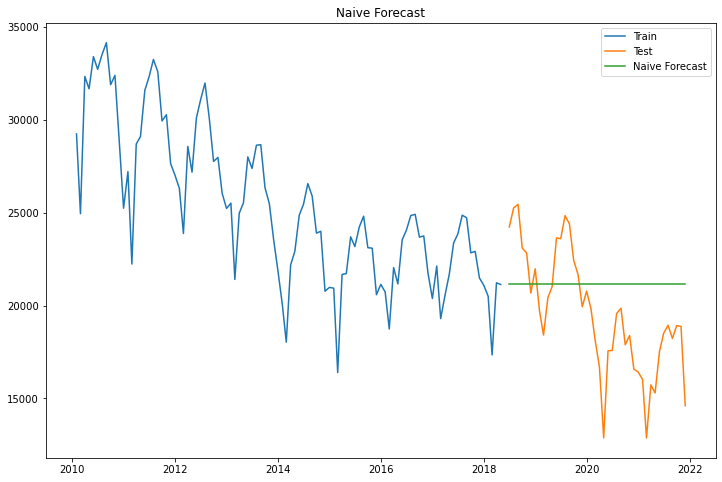

3572.321664048266

In [51]:
naive_forecast(train, test)

# Method 2: Holt Linear

In [52]:
def holt_linear(train, test):
    y_hat_avg = test.copy()
    fit = Holt(np.asarray(train['y'])).fit(smoothing_level = 0.3, smoothing_slope = 0.1)
    y_hat_avg['Holt_linear'] = fit.forecast(len(test))
    plt.figure(figsize = (16, 8))
    plt.plot(train['y'], label = 'Train')
    plt.plot(test['y'], label = 'Test')
    plt.plot(y_hat_avg['Holt_linear'], label = 'Holt_linear')
    plt.legend(loc = 'best')
    plt.show()
    rms = sqrt(mean_squared_error(test['y'], y_hat_avg['Holt_linear']))
    return rms

C:\Users\wuyiwei\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
<ipython-input-52-a8cb4ad39863>:3: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit = Holt(np.asarray(train['y'])).fit(smoothing_level = 0.3, smoothing_slope = 0.1)


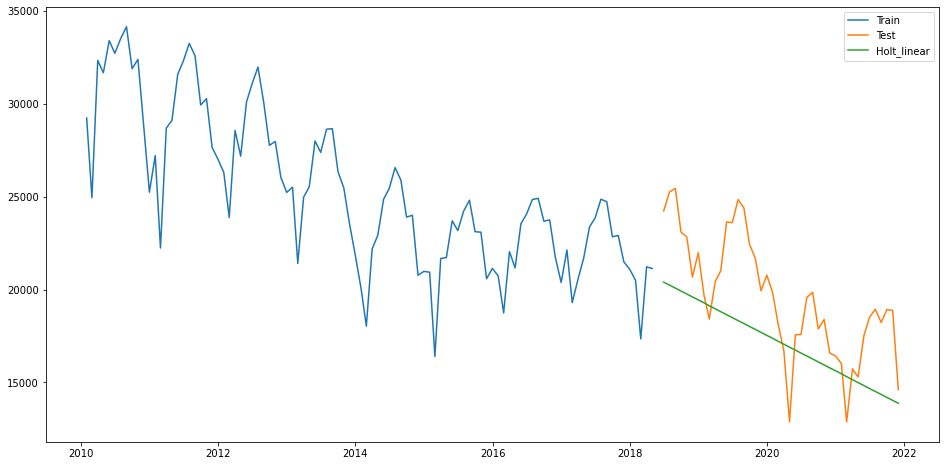

3284.9733454607344

In [53]:
holt_linear(train, test)

# Method 3: Holt Winter

In [54]:
def holt_Winter(train, test):
    y_hat_avg = test.copy()
    fit1 = ExponentialSmoothing(np.asarray(train['y']), seasonal_periods = 36, trend = 'add', seasonal = 'add', ).fit()
    y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
    plt.figure(figsize = (16, 8))
    plt.plot(train['y'], label = 'Train')
    plt.plot(test['y'], label = 'Test')
    plt.plot(y_hat_avg['Holt_Winter'], label = 'Holt_Winter')
    plt.legend(loc = 'best')
    plt.show()
    rms = sqrt(mean_squared_error(test['y'],y_hat_avg['Holt_Winter']))
    return rms

C:\Users\wuyiwei\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\wuyiwei\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


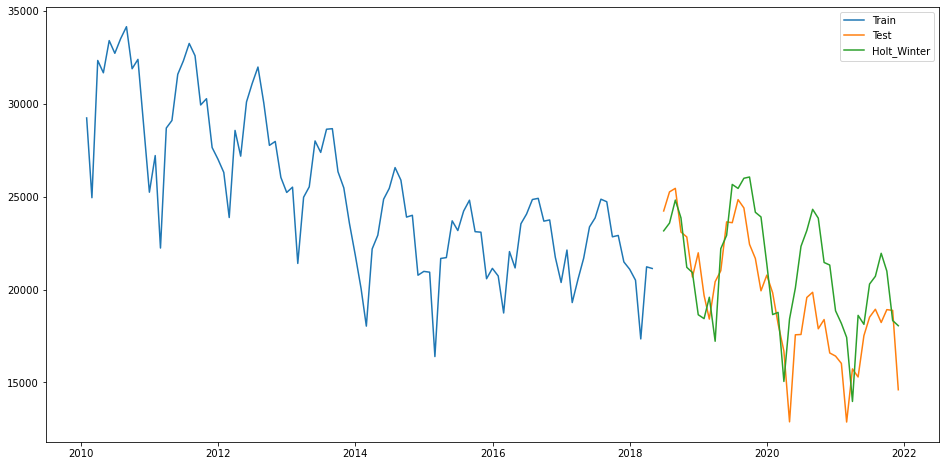

2774.8027729533537

In [55]:
holt_Winter(train, test)